# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.2.0

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [89]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "16 March 2022"

EXP_NAME_LIST = (
    "intensity1_AL48",    
    "intensity2_AL72",        
    "intensity3_AL96",            
    "intensity4_EPCP48",    
    "intensity5_EPCP72",        
    "intensity6_EPCP96",            
)
APPEND_NAME = '_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"

## Get the dataframe

In [3]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])
    
    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
    
        model_name = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        
        # load the metric filename
        metric_filename = METRIC_PATH + model_name + '_metrics.pkl'  
        if os.path.exists(metric_filename)==False:
            print(metric_filename + ' DOES NOT exist. Skipping...')
            continue
    
        # pprint.pprint(model_name)
        df = pd.read_pickle(metric_filename)
        df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]
        
        df_metrics = pd.concat([df_metrics,df])
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,pit_D_test,iqr_capture_test,iqr_error_spearman_test,iqr_error_pearson_test,iqr_error_spearman_p_test,iqr_error_pearson_p_test,...,iqr_error_spearman_p_valtest,iqr_error_pearson_p_valtest,cons_error_valtest,mean_error_valtest,median_error_valtest,mode_error_valtest,mean_error_reduction_valtest,median_error_reduction_valtest,mode_error_reduction_valtest,basin_lead
0,shash3,416,416,intensity1_AL48,0.028423,0.471751,0.313209,0.356684,1.697289e-09,4.645028e-12,...,5.423192e-16,1.005278e-18,11.845848,10.589066,10.402968,10.346209,1.256782,1.442880,1.499639,AL48
0,shash3,222,222,intensity1_AL48,0.016864,0.514124,0.331606,0.391127,1.563841e-10,2.181306e-14,...,2.091654e-17,1.259437e-20,11.436282,10.902426,10.705767,10.831227,0.533856,0.730515,0.605055,AL48
0,shash3,598,598,intensity1_AL48,0.021033,0.514124,0.358979,0.393105,3.313532e-12,1.572235e-14,...,4.902008e-20,6.862573e-24,11.482129,10.801982,10.577742,10.623646,0.680147,0.904387,0.858483,AL48
0,shash3,731,731,intensity1_AL48,0.022034,0.505650,0.296350,0.396233,1.313837e-08,9.325733e-15,...,4.231213e-19,7.824866e-26,11.367690,10.771135,10.552485,10.660108,0.596555,0.815205,0.707582,AL48
0,shash3,414,414,intensity1_AL48,0.027770,0.528249,0.277051,0.370896,1.168800e-07,5.491329e-13,...,9.757519e-16,9.955391e-21,10.931950,10.503452,10.158956,10.062635,0.428497,0.772993,0.869314,AL48
0,shash3,187,187,intensity1_AL48,0.021521,0.491525,0.300986,0.357689,7.581421e-09,4.007663e-12,...,9.604793e-19,2.572922e-20,11.679964,10.949736,10.697676,10.748917,0.730228,0.982288,0.931047,AL48
0,shash3,650,650,intensity1_AL48,0.027394,0.480226,0.323812,0.341564,4.380072e-10,4.018051e-11,...,1.065634e-15,7.772870e-19,10.924548,10.921641,10.558888,10.277617,0.002907,0.365660,0.646931,AL48
0,shash3,891,891,intensity1_AL48,0.016287,0.531073,0.329092,0.343178,2.186976e-10,3.209079e-11,...,3.875741e-20,7.009914e-21,11.560649,11.138134,10.884086,10.859206,0.422515,0.676563,0.701443,AL48
0,shash3,739,739,intensity1_AL48,0.024536,0.519774,0.326419,0.401884,3.113680e-10,3.578335e-15,...,9.089555e-21,5.882556e-25,11.724368,11.698095,11.330973,11.118953,0.026273,0.393395,0.605415,AL48
0,shash3,241,241,intensity1_AL48,0.017560,0.531073,0.333916,0.364204,1.145959e-10,1.520737e-12,...,3.124820e-18,1.529010e-22,11.483934,10.982239,10.765407,10.670217,0.501695,0.718527,0.813718,AL48


## Major summary for analysis

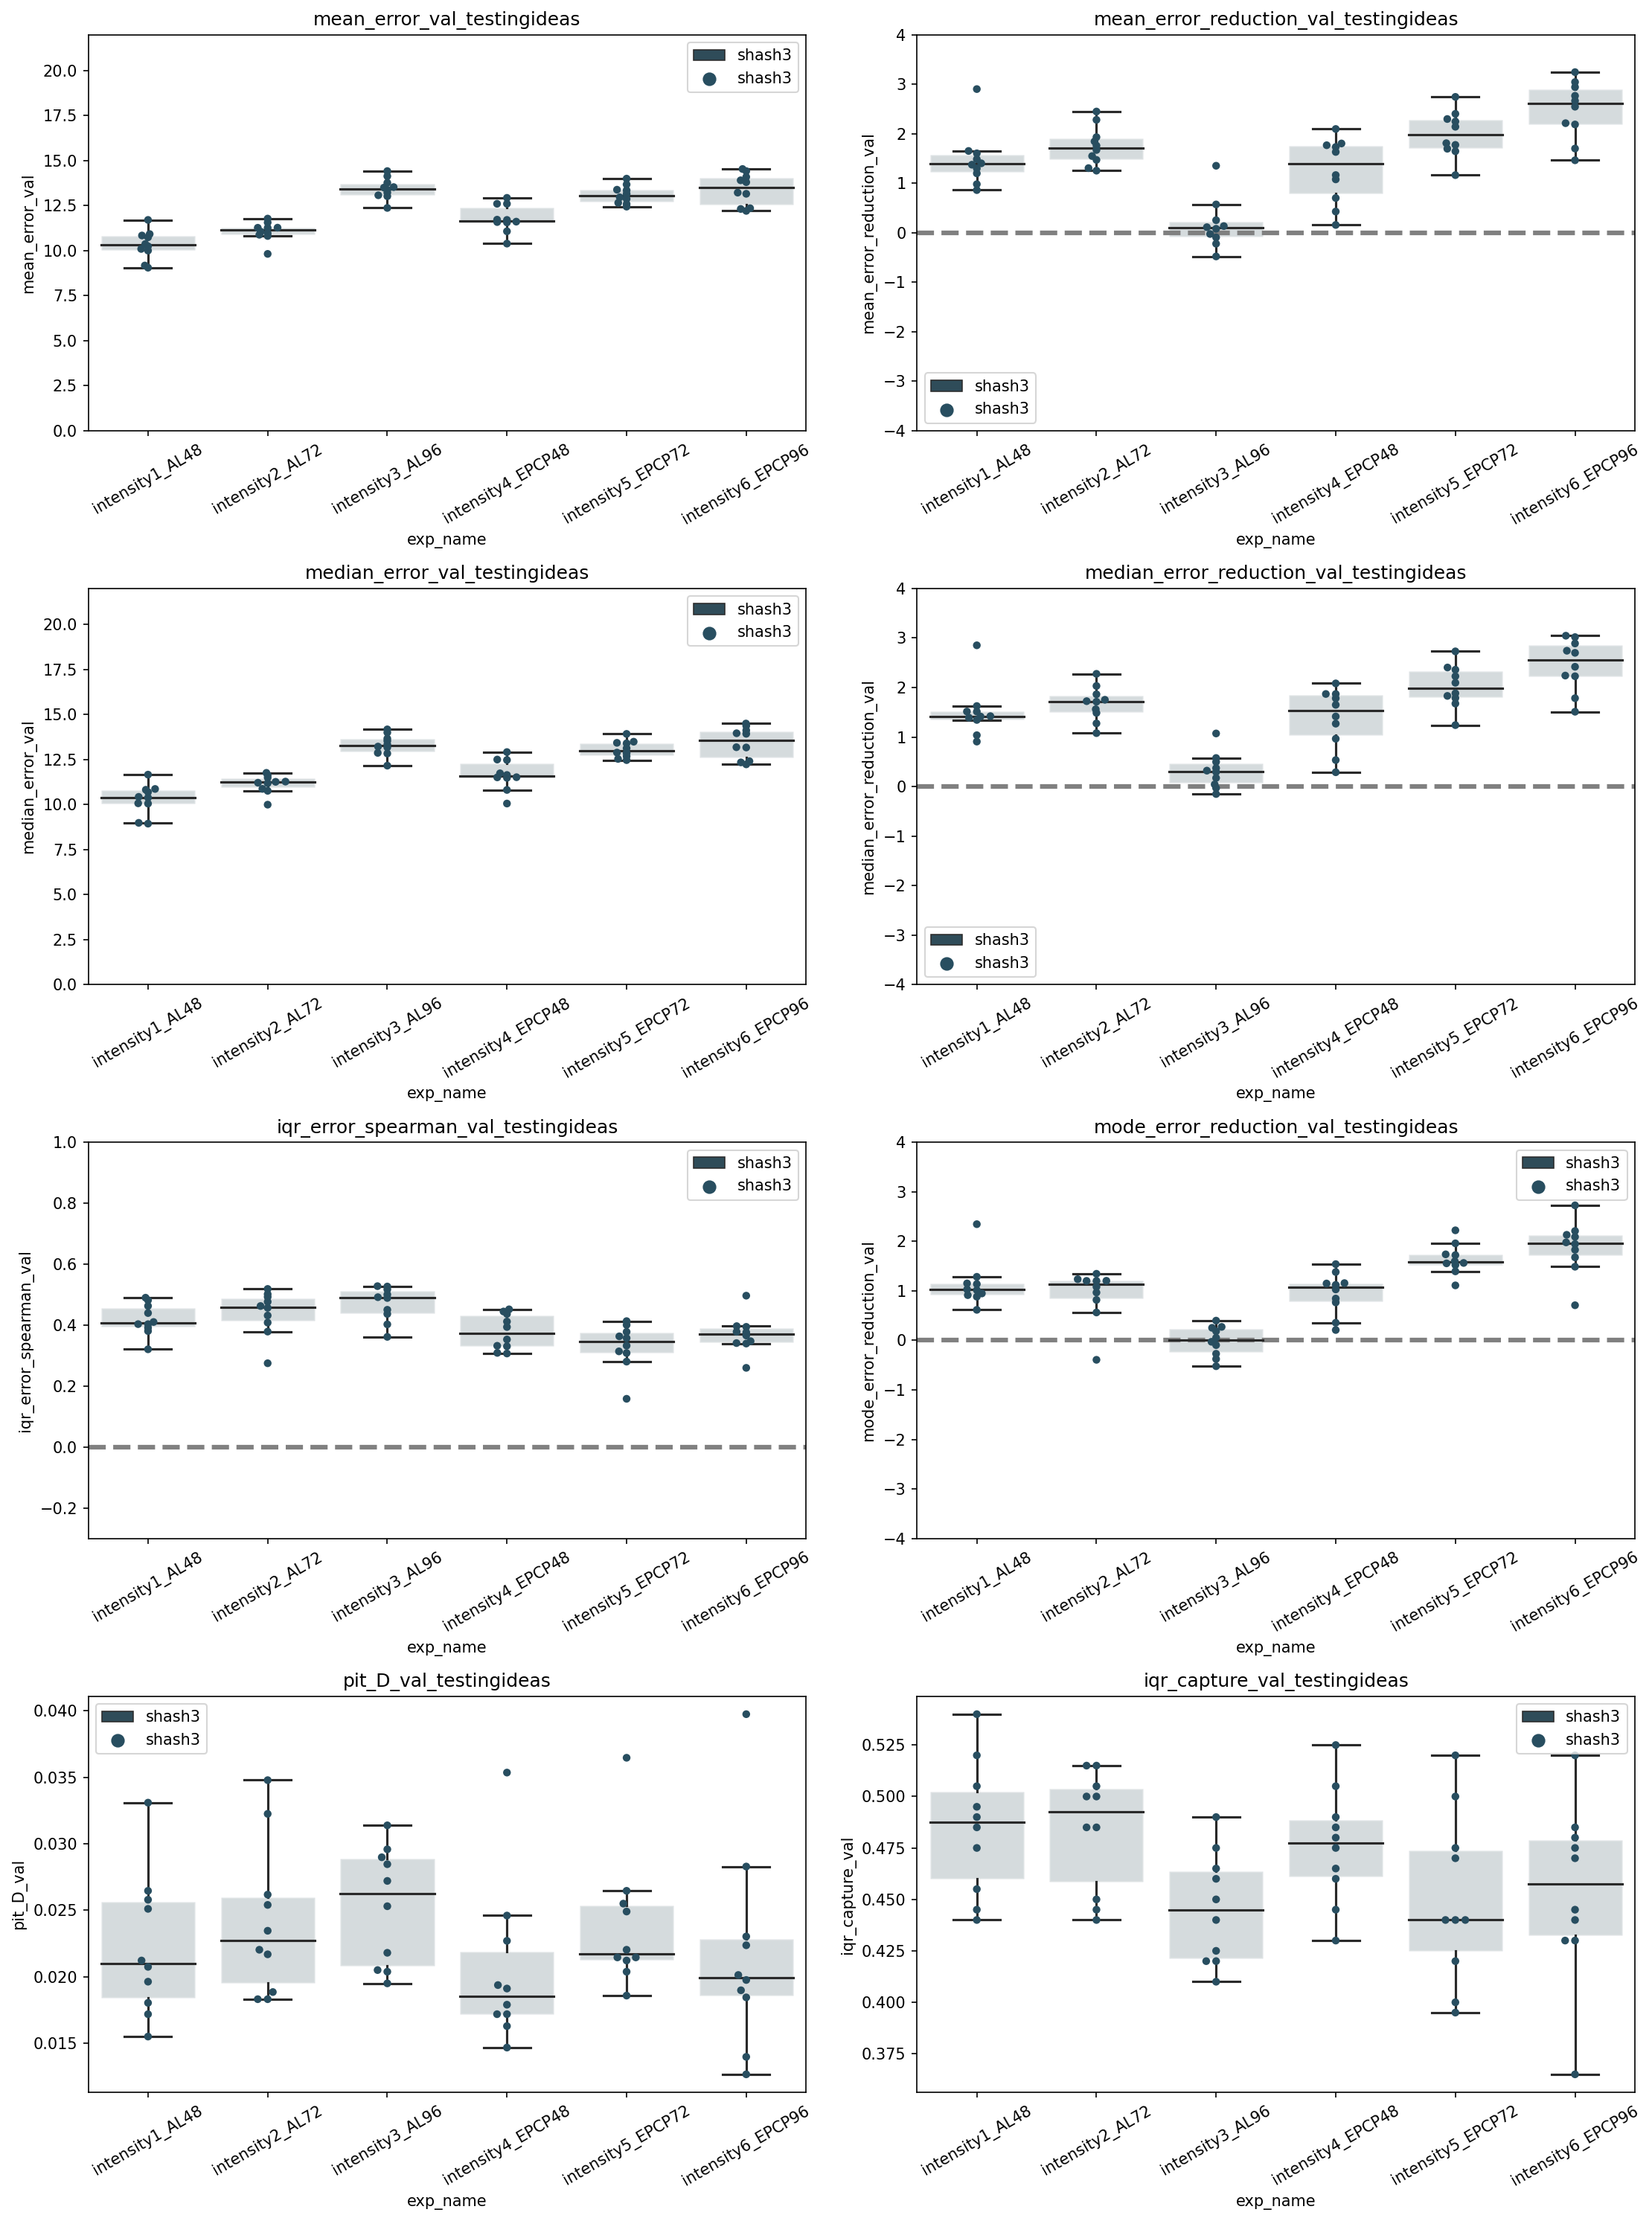

In [4]:
import seaborn as sns
colors = ('#284E60','#D95980','#E1A730','#C3B1E1')

x_axis_list = ("exp_name",)#("basin_lead",)#("basin_lead", "exp_name")

metric_list = ('mean_error',
              'mean_error_reduction',
              'median_error',
              'median_error_reduction',                                                                        
              'iqr_error_spearman',
              'mode_error_reduction',                                                                        
              # 'iqr_error_pearson',                                  
              # 'mode_error',
              'pit_D',
              'iqr_capture')
metric_data = '_val'

for x_axis in x_axis_list:
    f, axs = plt.subplots(4, 2, figsize=(15,20))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         boxprops={'alpha':.2,
                                   'edgecolor': 'white',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           dodge=True,
                           ax=ax)

        if(metric=='iqr_capture'):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric=='pit_d'):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-4.,4.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        


        ax.set_title(metric + APPEND_NAME)
        ax.legend(fontsize=10,frameon=True)
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

    plt.tight_layout()    
    # plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '_' + x_axis + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()

## Figure for main paper

In [55]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

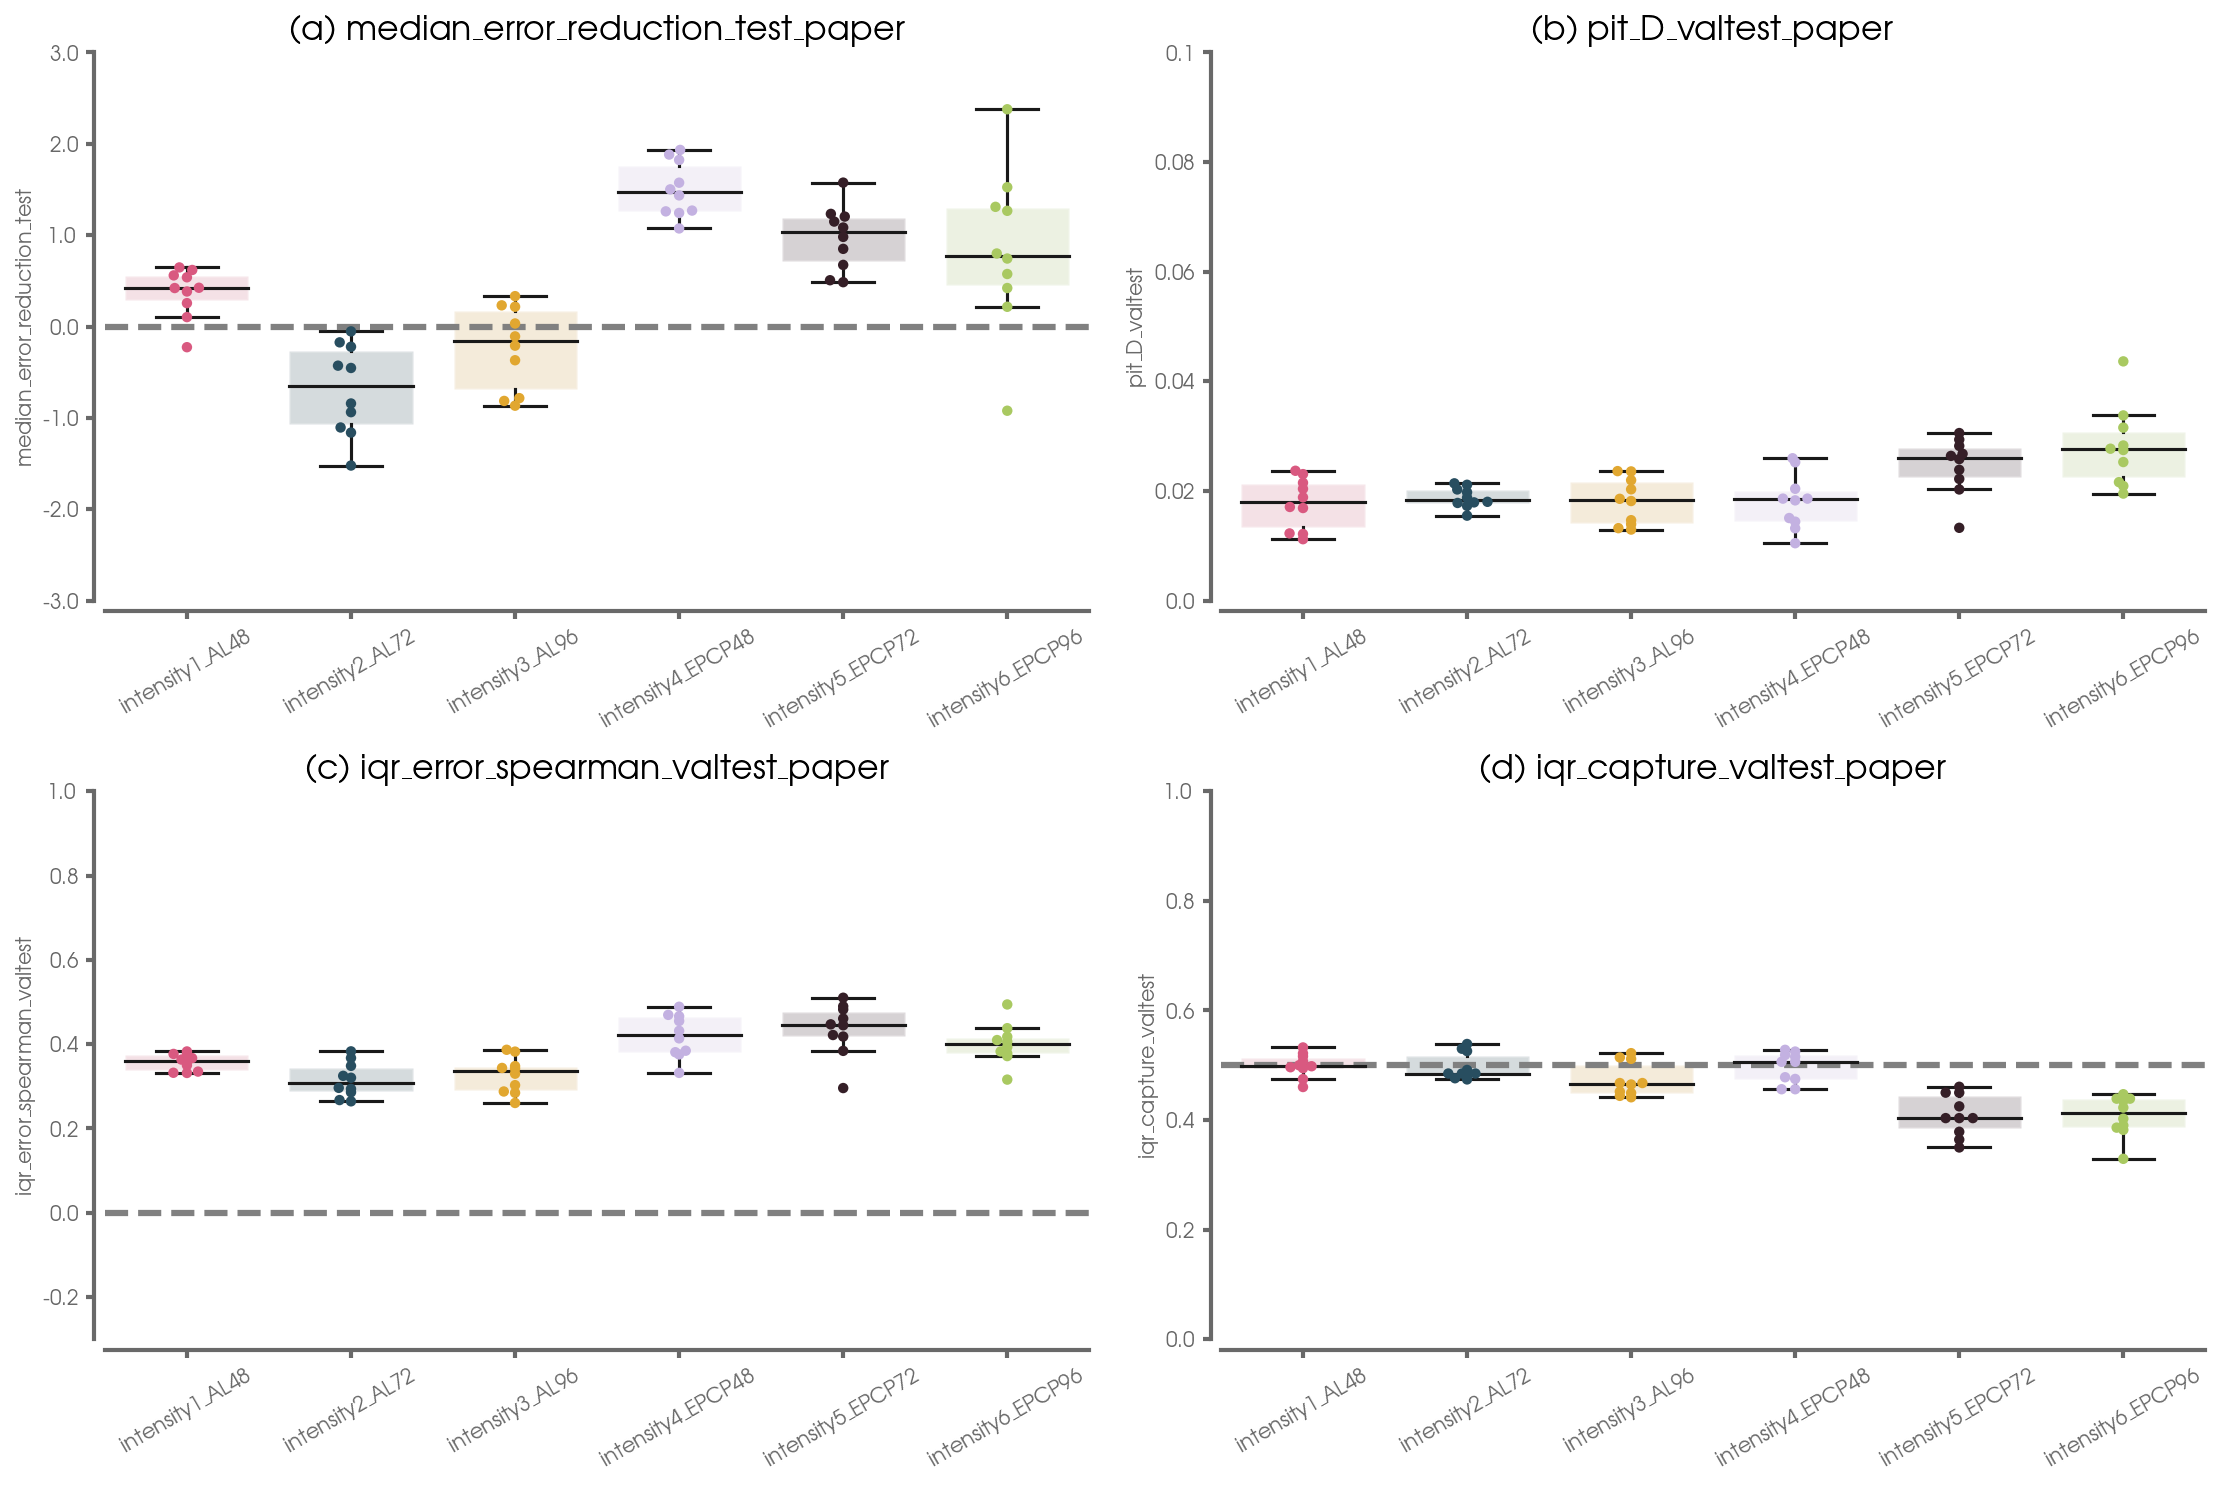

In [90]:
import seaborn as sns
colors = ('#D95980','#284E60','#E1A730','#C3B1E1','#351F27','#A9C961')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("exp_name",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="exp_name",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=False,
                         boxprops={'alpha':.2,
                                   'edgecolor': 'white',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="exp_name",
                           palette=colors,
                           data=df_metrics, 
                           dodge=False,
                           ax=ax)

        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,.1)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-3.,3.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

        ax.set_title(panel_letters[imetric] + ' ' + metric + APPEND_NAME,
                     fontsize=FS,
                     color='k',
                    )
        # ax.legend(fontsize=10,frameon=True)
        ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()

In [93]:
df_metrics.loc[df_metrics["exp_name"]=="intensity3_AL96"][["network_seed", "mode_error_reduction_val","median_error_reduction_val"]]

,network_seed,mode_error_reduction_val,median_error_reduction_val
0,416,0.054000,0.321128
0,222,-0.269998,0.372501
0,598,0.399000,0.576196
0,731,0.184999,0.293865
0,414,-0.521000,-0.030351
0,187,-0.027999,0.498372
0,650,0.273001,0.043239
0,891,0.254000,-0.150763
0,739,-0.376000,1.071858
0,241,-0.095000,0.173190


In [91]:
df_metrics.loc[df_metrics["exp_name"]=="intensity4_EPCP48"][["network_seed", "mode_error_reduction_val","median_error_reduction_val"]]

,network_seed,mode_error_reduction_val,median_error_reduction_val
0,416,1.029000,1.649831
0,222,0.210001,0.534411
0,598,1.540000,1.414899
0,731,1.381000,1.868733
0,414,0.766999,0.965257
0,187,1.149001,1.869185
0,650,1.120999,1.781460
0,891,0.356000,0.288739
0,739,0.845000,2.082871
0,241,1.157001,1.269702
